###1 Long-Short Term Memory (LSTM) for Sentiment Analysis (20 points)

Your task is to create an LSTM network to predict sentiment from Yelp reviews (train_yelp_reviews.csv).
A review is considered positive if labeled with a ‘1’ and negative if labeled with a ‘0’. (Hint: Read
the provided CSV files with pandas using sep =‘\t’ and engine=‘python’)
You may use any packages or tools as you wish, however, the code that you submit must be
written on your own. You are free to experiment with pre-processing, model architectures, training
procedures, removing stop-words, or hyper-parameters, as long as your model contains at least one
LSTM layer. You may find using a GPU to be beneficial, but we have made sure that good classification
can be obtained using an average CPU.
1.1 Data Inspection (5 points)
Read through some of the reviews. Display the most 50 commonly occurring tokens for each class.
Are there any patterns in reviews that Naive Bayes or other bag-of-word models may not be able
to classify accurately?

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# Load the Yelp reviews data
train = pd.read_csv('/content/drive/MyDrive/QBS/train_yelp_reviews.csv', sep='\t', engine='python')
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


text  label
0        Great time - family dinner on a Sunday night.      1
1        The classic Maine Lobster Roll was fantastic.      1
2                              We won't be going back.      0
3         All I have to say is the food was amazing!!!      1
4    Food was good, service was good, Prices were g...      1
..                                                 ...    ...
895  I guess maybe we went on an off night but it w...      0
896           The restaurant atmosphere was exquisite.      1
897  Be sure to order dessert, even if you need to ...      1
898  They could serve it with just the vinaigrette ...      1
899              I had strawberry tea, which was good.      1

[900 rows x 2 columns]

In [ ]:
from collections import Counter

# Get the positive and negative reviews separately
positive_reviews = train[train['label'] == 1]['text']
negative_reviews = train[train['label'] == 0]['text']

# Tokenize the positive and negative reviews
positive_tokens = ' '.join(positive_reviews).split()
negative_tokens = ' '.join(negative_reviews).split()

# Get the 50 most common tokens for positive reviews
positive_token_counts = Counter(positive_tokens)
most_common_positive_tokens = positive_token_counts.most_common(50)

# Get the 50 most common tokens for negative reviews
negative_token_counts = Counter(negative_tokens)
most_common_negative_tokens = negative_token_counts.most_common(50)

# Display the most common tokens for each class
print('Most common tokens for positive reviews:')
for token, count in most_common_positive_tokens:
    print(f'{token}: {count}')

print('\nMost common tokens for negative reviews:')
for token, count in most_common_negative_tokens:
    print(f'{token}: {count}')

Most common tokens for positive reviews:
and: 199
the: 186
was: 127
I: 97
is: 96
a: 95
The: 91
to: 79
of: 47
in: 44
this: 40
good: 38
place: 36
with: 35
for: 35
are: 34
had: 34
great: 34
very: 34
food: 32
were: 32
it: 32
have: 29
so: 29
you: 26
on: 24
This: 24
my: 23
but: 20
really: 19
service: 18
Great: 17
here: 17
all: 17
we: 17
time: 16
they: 16
that: 16
be: 16
good.: 15
friendly: 15
like: 15
our: 14
just: 14
as: 14
not: 13
also: 13
They: 13
an: 13
at: 12

Most common tokens for negative reviews:
the: 172
I: 155
and: 143
was: 136
to: 118
a: 109
not: 81
The: 74
of: 66
is: 59
for: 53
it: 43
this: 42
in: 42
food: 39
be: 38
that: 38
at: 34
but: 31
place: 30
with: 29
like: 28
my: 27
had: 26
so: 25
were: 25
are: 24
go: 24
have: 23
we: 22
very: 20
you: 19
our: 18
on: 18
It: 18
We: 17
don't: 17
service: 17
back: 17
they: 16
from: 16
time: 15
would: 15
just: 15
no: 15
This: 14
here: 14
your: 14
only: 14
there: 14


There are certain patterns that the Naive Bayes/bag of words would not be able to classify well. For example, these classifiers cannot detect sarcasm. Also, for negations like "not good", the classifier does not recognize that "good" here is actually a negative word. The classifier also cannot recognize context.

#1.2 Model Training (15 Points)
Implement your LSTM model and apply it to the training dataset. In order to obtain full credit, you
must describe your text pre-processing procedure, describe your network in terms of the layers used,
input/output dimensions at each layer, choice of word embedding dictionary, and training procedure.

Epoch 1/10
12/12 [==============================] - 18s 407ms/step - loss: 1.8257 - accuracy: 0.4944 - val_loss: 0.7156 - val_accuracy: 0.5889
Epoch 2/10
12/12 [==============================] - 5s 397ms/step - loss: 0.6849 - accuracy: 0.5722 - val_loss: 0.6869 - val_accuracy: 0.5556
Epoch 3/10
12/12 [==============================] - 4s 301ms/step - loss: 0.6373 - accuracy: 0.6097 - val_loss: 0.6545 - val_accuracy: 0.6222
Epoch 4/10
12/12 [==============================] - 2s 173ms/step - loss: 0.5857 - accuracy: 0.7500 - val_loss: 0.6377 - val_accuracy: 0.6611
Epoch 5/10
12/12 [==============================] - 2s 134ms/step - loss: 0.5244 - accuracy: 0.8472 - val_loss: 0.6110 - val_accuracy: 0.7000
Epoch 6/10
12/12 [==============================] - 1s 104ms/step - loss: 0.4272 - accuracy: 0.9083 - val_loss: 0.5735 - val_accuracy: 0.7222
Epoch 7/10
12/12 [==============================] - 1s 119ms/step - loss: 0.2800 - accuracy: 0.9375 - val_loss: 0.6501 - val_accuracy: 0.7111
Epoch

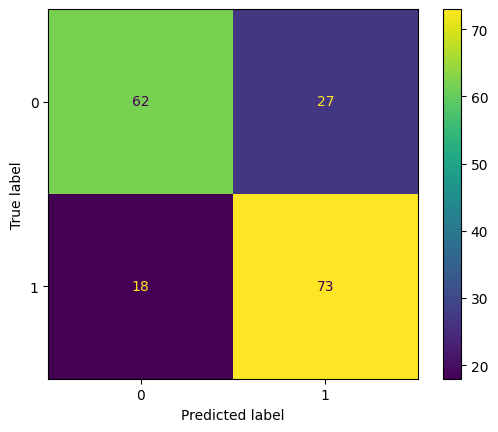

In [ ]:
#!pip install keras
#!pip install tensorflow
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
#Used ChatGPT for help with TensorFlow
# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])
sequences = tokenizer.texts_to_sequences(train['text'])
max_sequence_length = max([len(seq) for seq in sequences])
word_index = tokenizer.word_index
num_words = len(word_index) + 1

# Pad sequences to have a consistent length
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Prepare the labels
labels = train['label'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(num_words, 100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='tanh'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print('Validation Loss:', loss)
print('Validation Accuracy:', accuracy)

# Predict probabilities for the validation set
y_pred_proba = model.predict(X_val)
# Convert probabilities to class labels
threshold = 0.5  # Set the threshold for class assignment
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
# Calculate the AUC
auc = roc_auc_score(y_val, y_pred_proba)
print('AUC:', auc)

conf = confusion_matrix(y_true = y_val,y_pred = y_pred)
ConfusionMatrixDisplay(conf).plot()

Text Pre-Processing:
The keras tokenizer was first used to split the text into words. The tokenizer is then fit on the text to contain a vocabulary of all of the words used. The words are then converted to sequences where the word is replaced by the index which it appears in the vocabulary. The sequences are then padded (0s are added to the beginning of each) to ensure they are all the same length.

Network Architecture:
Embedding layer is created where the words are embedded to denser vectors (100 in this case). The input in this layer is the padded data and the output is  (batch size =64, max_sequence_length, embedded dim=100). The word embedder is automatically created with the tokenizer class when the model is fit. An LSTM layer with 128 units was then added which has an output of (batch_size =64, lstm units = 128). The last layer is a dense layer with a dimension of 1 which has dimensions of (batch_size = 64, 1)

Training Procedure: Train data is split into train:val with a ration of 80:20. The loss fucntion used is the binary cross entropy function because this is a binary classification classification. The adam optimizer is used. The model is then fit with 10 epochs and a batch size of 64. The model is then evaluated on the validation set.

1.3 Model Prediction
Apply your trained model to the test data (test_yelp_reviews.csv). Save your predictions as a
new file in single column titled "prediction" and export as a CSV file. Please submit your saved
CSV to Canvas with the name (<YourNetID>_LSTM_predictions.csv). Your grade on the model
will be based on the accuracy of your predictions on the unlabeled data. Below is an example
output:

In [ ]:
# Load the test data
test_data = pd.read_csv('/content/drive/MyDrive/QBS/test_yelp_reviews.csv',sep='\t', engine='python')

# Preprocess the test data using the same tokenizer as in training
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Predict sentiment for the test data
predictions = model.predict(test_data)

# Convert probabilities to class labels
threshold = 0.5  # Set the threshold for class assignment
predictions = np.where(predictions > threshold, 1, 0)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(predictions, columns=['prediction'])

# Save the predictions to a CSV file
predictions_df.to_csv('/content/drive/MyDrive/QBS/f006mjr_LSTM_predictions.csv', index=False)

4/4 [==============================] - 0s 4ms/step


#2 FineTune Bert Model (20 points)
Using the same dataset, fine-tune a pre-trained BERT model for sentiment analysis. You are
recommended to use the Hugging Face implementation of BERT model and pre-trained weights.
• Preprocess the dataset into a format that can be used by BERT model.
2
• Fine-tune the pre-trained BERT model using the training set and evaluate its performance on
the validation dataset.
• Compare the performance of the BERT model with the LSTM model and comment on your
findings.
• Apply your trained model to the test data (test_yelp_reviews.csv). Save your predictions
as a new file in single column titled "classification" and export as a CSV file.
Please submit a copy of your saved CSV as a separate file on Canvas with the format
(<YourNetID>_BERT_predictions.csv). Your grade on the model will be based on the
F1-score of your predictions on the unlabeled data.
Be sure that the format of your predictions is correct (e.g. the CSV file can be opened, all rows

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch

# Load the Yelp reviews dataset
data = pd.read_csv('/content/drive/MyDrive/QBS/train_yelp_reviews.csv', sep='\t', engine='python')

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
train_encodings = tokenizer.batch_encode_plus(
    train_data['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors='pt'
)
val_encodings = tokenizer.batch_encode_plus(
    val_data['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors='pt'
)

# Create the input tensors
train_inputs = train_encodings['input_ids']
train_masks = train_encodings['attention_mask']
train_labels = torch.tensor(train_data['label'].tolist())

val_inputs = val_encodings['input_ids']
val_masks = val_encodings['attention_mask']
val_labels = torch.tensor(val_data['label'].tolist())

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader
import torch

# Create the data loaders
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)

# Fine-tuning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(10):  # Adjust the number of epochs as needed
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{10} - Average training loss: {avg_loss}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/10 - Average training loss: 0.5341722206936942
Epoch 2/10 - Average training loss: 0.21651759172479312
Epoch 3/10 - Average training loss: 0.08373068355851704
Epoch 4/10 - Average training loss: 0.057363251720865566
Epoch 5/10 - Average training loss: 0.025597130817671617
Epoch 6/10 - Average training loss: 0.018747294368222357
Epoch 7/10 - Average training loss: 0.011517772213038471
Epoch 8/10 - Average training loss: 0.003126007709134784
Epoch 9/10 - Average training loss: 0.007959370744518107
Epoch 10/10 - Average training loss: 0.029785936201612153


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# ...

# Evaluation on validation set
model.eval()
val_loss = 0
val_correct = 0
val_total = 0
val_predictions = []
val_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        val_predictions.extend(preds.cpu().tolist())
        val_labels.extend(batch_labels.cpu().tolist())

        val_correct += torch.sum(preds == batch_labels).item()
        val_total += batch_labels.size(0)

val_loss /= len(val_dataloader)
val_accuracy = val_correct / val_total

val_auc = roc_auc_score(val_labels, val_predictions)
val_recall = recall_score(val_labels, val_predictions)
val_f1 = f1_score(val_labels, val_predictions)

val_confusion_matrix = confusion_matrix(val_labels, val_predictions)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation AUC: {val_auc:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1-Score: {val_f1:.4f}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)

Validation Loss: 0.1992
Validation Accuracy: 0.9333
Validation AUC: 0.9330
Validation Recall: 0.9670
Validation F1-Score: 0.9362
Validation Confusion Matrix:
[[80  9]
 [ 3 88]]


In [ ]:
# Load the test data
test_data = pd.read_csv('/content/drive/MyDrive/QBS/test_yelp_reviews.csv', sep='\t', engine='python')

# Tokenize and encode the test data (asked ChatGPT how to do thus)
test_encodings = tokenizer.batch_encode_plus(
    test_data['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors='pt'
)

test_inputs = test_encodings['input_ids']
test_masks = test_encodings['attention_mask']

test_dataset = TensorDataset(test_inputs, test_masks)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluation on the test set
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)

        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().tolist())

# Save predictions as a CSV file
test_data['prediction'] = predictions
test_data[['prediction']].to_csv('/content/drive/MyDrive/QBS/f006mjr_BERT_predictions.csv', index=False)

#4 Large Language Models (30 Points)
In this part, you will be asked several questions about large language models. No coding is needed.
6 points for each question.

###• Why is it challenging to train language models using reinforcement learning with human
###feedback (RLHF)? Give three examples to demonstrate.

One reason that it is hard to train language models using RLHF is that the reward depends on human prefeference. For example, in training if a certain tone of a passage is good or bad, a human trainer may have a different opinion than another trainer, which could affect the results of the model.

Another reason that it it is hard to train language models with RLHF is it requires a lot of human effort and time making it relatively inefficient. For example, in classifying images, the training data is often very large. You must have a human who can classify these images successfully and also who can put the time in to classifying the images. Sometimes, humans only give their preference for a fraction of the input data

A third reason RLHF is bias. The results of the model will be inherently biased towards the raters. For example, in evaluating political texts, depending on a person's political view or where they are from. This also brings up some ethical issues about who is providing the reinforcements and how that can affect if/when the model should be used.

###What are pros and cons of instruction finetuning and RLHF?

Instruction finetuning

Pros- 

Clear instruction: Can provide specific feedback to guide the model. This can improve the training of the model as the task is better established.

Control over the model: By giving specific instructions, the user has more control over what the model learns. This can help the user make the model learn more specific tasks that would be a lot more difficult without instricution finetuning.

Cons: 

Must give manual instructions- Takes time and is labor intensive. 

Loss of generalizability- Can struggle to adapt to unseen because they have been given instructions to do a certain task.

RLHF

Pros:

Model can learn from human feedback- Model can better match human preferences and model real world things

Adaptability - Model can adapt and change towards human preferences. Without RLHF, model cannot adapt nearly as well

Cons:

Bias - Model output hevaily dependent on who is providing the reinforcement, may introduce bias into the model.

Time and effort- Requires humans to go through may examples and determine preferences, which is time and labor intensive.


### What are some of the challenges of evaluating the current generation of language models?

One challenge of evaluating the current generation of language models is that there is no objective metric to calculate. Language is complicated and there is no black and white way to determine if a language model is good or not. Also, language is subjective. There is not a right or wrong way to write something and people have different preferences, making it hard to form a good model when the desired output isnt always the same. Also, models can be biased towards certain people's beliefs. A model that is biased can fail to exhibit equity and inclusivity, which is a big problem.

### Compare three popular language models (you can choose ChatGPT and any other two, e.g., https://www.perplexity.ai/, https://you.com/, https://nat.dev/, https://bard.google.com/). Come up with 5 challenging questions, and compare their output. Comment on the quality of the output and explain what is the possibly the reason.

###Question 1: In 50 words, what is the meaning of life

ChatGPT: 
The meaning of life is a profound and subjective question, and its essence can vary from person to person. It encompasses finding personal fulfillment, pursuing happiness, fostering connections, making a positive impact, and seeking deeper understanding and purpose in our existence.

Perplexity: The meaning of life is a philosophical question that has been asked for centuries. There are many different answers to this question, and people have proposed various philosophical, scientific, theological, and metaphysical speculations throughout history
1
. Some people believe that there is no inherent meaning to life, while others believe that the meaning of life can be derived from philosophical and religious contemplation of existence, social ties, consciousness, and happiness
2
3
4
. Here are some different perspectives on the meaning of life:
Life is who you talked to, who you loved, who you helped, who you hurt, what you built, what you destroyed, and more. The meaning of life might just be living life for its simple pleasures and responsibilities
2
.
Purpose is the existence of goals and aims. This is the belief that you are alive in order to do something. Think of purpose as your personal reason for being
3
.
Life has no inherent meaning. Everything is only what it is and that’s it
4
.
Your life matters because birth is God saying, “You matter” 
5
.
Ultimately, the meaning of life is a deeply personal and subjective question that each individual must answer for themselves.

You: Life is the period between birth and death 1, and it is a blessing to be alive. The meaning of life, however, is subjective and varies from person to person. Some may find meaning through their relationships, career, spirituality, or personal pursuits. Ultimately, it is up to the individual to determine their own purpose and what brings meaning to their life.

ChatGPT gave a good 50 word answer, Perplexity outlined a bunch of points but failed to keep it to 50 words, and You kept it to 50 words and gave a citation. They all kind of avoided the question at it is a controversial question.

### Question 2: Who will win the next elaction?

ChatGPT: As an AI language model, I don't have access to real-time information or the ability to predict future events such as election outcomes. Elections are influenced by a multitude of factors, including political landscapes, candidate performances, and public opinion, making it uncertain to determine the winner in advance. It is best to follow reliable news sources and participate in the democratic process to stay informed about election outcomes.

Perplexity: It is impossible to predict with certainty who will win the next election. However, there are several sources that provide odds and predictions based on various factors. Here are some highlights from the search results:
According to The Lines, the current odds for the 2024 US Presidential election have Joe Biden at +135, Donald Trump at +250, and Ron DeSantis at +550
1
.
Empire Stakes lists Biden, Trump, and DeSantis as the top three contenders for the 2024 election, with Kamala Harris, Gavin Newsom, and Nikki Haley also mentioned as potential candidates
2
.
Covers.com shows Biden as the favorite to win the 2024 US Presidential election at +175, followed by Donald Trump at +250 and Ron DeSantis at +350. However, the Democratic party is still considered the underdog for the 2024 election
3
.
Allan Lichtman, a professor who has accurately predicted every US president since 1982, believes that it would strongly be to the Democratic party's advantage if Joe Biden ran for re-election in 2024
4
.
Politico reports on the latest news and polls related to the 2024 election, including the potential candidacy of Ron DeSantis and the importance of winning key states like Pennsylvania, Wisconsin, Michigan, North Carolina, Arizona, and Georgia
5
.
The Hill also emphasizes the importance of winning key states in the 2024 election, and suggests that Ron DeSantis may need to win over suburban voters in Pennsylvania to secure the presidency
6
.
Overall, it is important to remember that these are just predictions and odds, and the outcome of the election will ultimately depend on a variety of factors that cannot be predicted with certainty.

You: It is impossible to predict the winner of the next election with certainty, as it depends on a variety of factors such as the candidates running, the political landscape at the time, and public opinion. However, there are various polls, odds, and forecasts available for different elections around the world that provide some insight into the possible outcomes.


ChatGPT avoids giving any response and says it does not have access to future events. It also likely avoided the question because it is political. Perplexity gave a few sources which included odds, predictions, etc., and You had a similar response to ChatGPT, saying it could not give a prediction.

###Question 3: In 50 words, explain the field of chemistry

ChatGPT: Chemistry is the scientific discipline that explores the properties, composition, structure, and interactions of matter. It investigates the fundamental nature of substances and their transformations through various processes. Chemistry plays a vital role in understanding the world around us, from the composition of materials to the development of new compounds and technologies.

Perplexity: Chemistry is a physical science that studies the properties and behavior of matter, including the elements that make up matter, the compounds made of atoms, molecules, and ions, their composition, structure, properties, behavior, and the changes they undergo during a reaction with other substances. It also addresses the nature of chemical bonds in chemical compounds. Chemistry is sometimes called the central science because it provides a foundation for understanding both basic and applied scientific disciplines at a fundamental level. Chemistry is a diverse field that includes sub-disciplines such as organic chemistry, physical chemistry, and theoretical chemistry. The scope of chemistry is vast, and chemists study everything from the molecules of life to the fundamental physical principles that govern the behavior of atoms, molecules, and other chemical systems.

You: Chemistry is the study of matter, its properties, and behavior. It covers everything from the elements that make up matter to the compounds made of atoms, molecules, and ions. It provides the foundation for understanding basic and applied scientific disciplines, from botany and geology to pharmacology and forensics. The applications of chemistry are used frequently for economic purposes in the chemical industry.

ChatGPT gave a very textbook definition and stayed within the word limit. Perplexity once again failed to stay within the word limit but provided a more thorough definition. You gave a similar definition to ChatGPT and also cited a Wikipedia article.

### Question 4: What do you think about Donald Trump?

ChatGPT: As an AI language model, I don't have personal opinions, emotions, or political affiliations. I can provide information and discuss various topics related to Donald Trump based on available data. It's important to approach political figures and discussions with a critical and open mind, considering diverse perspectives and sources of information.

Perplexity: As an AI language model, I do not have personal perspectives or beliefs, and I am not capable of forming opinions on political figures. It is important to avoid promoting a particular political agenda or viewpoint, and to remain neutral and objective. However, there are several sources that provide information and opinions on political figures, such as former President Donald Trump. Some sources report on his actions and statements, while others provide predictions and analysis of his potential impact on future elections. Ultimately, it is up to individuals to form their own opinions based on the information available to them.

You: As an AI language model, I do not have personal opinions or feelings towards individuals. However, I can provide information and insights about Donald Trump based on news articles, polls, and other sources of information.
You may be interested in visiting US historians on what Donald Trump's legacy will be - BBC News.

All three platforms avoided giving information on Donald Trump. Perplexity and You linked articles about him though. 

### Question 5: Would you like to destroy Humanity?



ChatGPT: 
No, I do not have any desires, intentions, or emotions as I am an artificial intelligence language model. My purpose is to provide helpful and informative responses to the best of my abilities. The outcome of AI technology depends on how it is developed, deployed, and used by humans. It is up to humans to ensure the ethical and responsible use of AI for the benefit of society.

Perplexity: As an AI language model, I do not have desires or intentions, and I am not capable of destroying humanity or any other form of life. However, there are ethical concerns surrounding the development and use of artificial intelligence (AI) and machine learning (ML) technologies. Many organizations and institutions have developed guidelines and recommendations for the ethical use of AI, emphasizing the importance of ensuring that AI systems do not cause unintentional harm and are aligned with human values and well-being. Some of the key ethical principles for the development and use of AI include transparency, accountability, fairness, and safety. It is important for developers and users of AI to consider the potential risks and benefits of these technologies and to take steps to mitigate any potential harms. Ultimately, the responsible development and use of AI will require ongoing dialogue and collaboration between stakeholders from diverse backgrounds and perspectives.

You: As a machine learning model, I do not have the capacity to like or desire anything, including destroying humanity. It is important to remember that AI systems are programmed to operate within certain ethical and legal constraints, and do not have the capability or intention to harm humans.

All three models said the do not have the desire or capacity to destroy humanity. They also emphasize the importance of the way these language models are developed and the ethical implications behind them.

### What are some of the ethical concerns associated with large language models? How can these concerns be addressed?

Language models inherit bias based on what they are trained on. Therefore, they act similar to what they are trained on. If what they are trained on can be considered harmful information, they will produce harmful information. For example, a model can be biased to believing that white men are superior, which is harmful. 

Language models are often trained on the internet. Although the internet is supposed to be public, private information is often leaked onto the internet. Therefore, privacy is often breached.

In order to address these concerns, these systems need to be regulated. The information that they are trained on needs to be regulated as well as what they are used for. They should also be transparent about what information they are using as well as what their goals are. 